## Redes Neurais Artificiais 2025.1

- **Disciplina**: Redes Neurais Artificiais 2025.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  

|Alunos                |Matrícula  |
|----------------------|-----------|
|Caio Bertoldo         |2215080050 |
|Danilo Jorge          |2215080007 |
|Diogo Gomes           |2215080033 |
|Guilherme Montenegro  |2215080011 |
|Leonardo Abinader     |2215080042 |
|Rodolfo Simões        |2215080073 |

### Tarefa de aprendizado - Gradient Boosting

### Gradient Boosting

O algoritmo Gradient Boosting é uma técnica de aprendizado de máquina para problemas de regressão e classificação que produz um modelo de previsão a partir de uma combinação de modelos de previsão fracos, geralmente árvores de decisão.

O objetivo do algoritmo é criar uma corrente de modelos fracos, onde cada um tem como objetivo minimizar o erro do modelo anterior, por meio de uma função de perda.

Aos ajustes de cada modelo fraco é multiplicado um valor chamado de taxa de aprendizagem. Esse valor, tem como objetivo determinar o impacto de cada árvore no modelo final. Quanto menor o valor, menor a contribuição de cada árvore.

Nesta primeira parte, será construído o modelo de Gradient Boosting utilizando uma técnica de divisão de dados fixa na proporção de 70/30. Além disso, faremos a implementação desse modelo com e sem a técnica de early stopping, que auxilia na análise do aprendizado do modelo e interrompe ao perceber que o mesmo chegou em um estágio sem melhorias.

In [226]:
# Bibliotecas
import os
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, log_loss, roc_auc_score


##### Sem early stopping

In [227]:
# Utilizando os dados codificados
df = pd.read_csv('datasets/updated_pollution_dataset_encoded.csv')

In [228]:
# Separando o atributo alvo dos preditores
X = df.drop('Air Quality Encoded', axis=1)
y = df['Air Quality Encoded']

In [229]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Definindo o modelo e seus hiperparâmetros
clf = GradientBoostingClassifier(n_estimators=200, 
                                learning_rate=0.05, 
                                max_depth=3,
                                min_samples_split= 5,
                                min_samples_leaf=5,
                                subsample= 0.8,
                                random_state=42)

In [231]:
# Treinando o modelo com dados de treino
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=5,
                           min_samples_split=5, n_estimators=200,
                           random_state=42, subsample=0.8)

In [232]:
y_pred_gb = clf.predict(X_test)
# print(y_pred_gb)

In [233]:
y_pred_gb = clf.predict(X_test)
acuracia_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='macro')
precisao_gb = precision_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')
print(f"Métricas \nAcurácia: {acuracia_gb:.2f} \nF1-score: {f1_gb:.2f} \nPrecisão: {precisao_gb:.2f} \nRecall: {recall_gb:.2f}")

Métricas 
Acurácia: 0.96 
F1-score: 0.93 
Precisão: 0.94 
Recall: 0.93


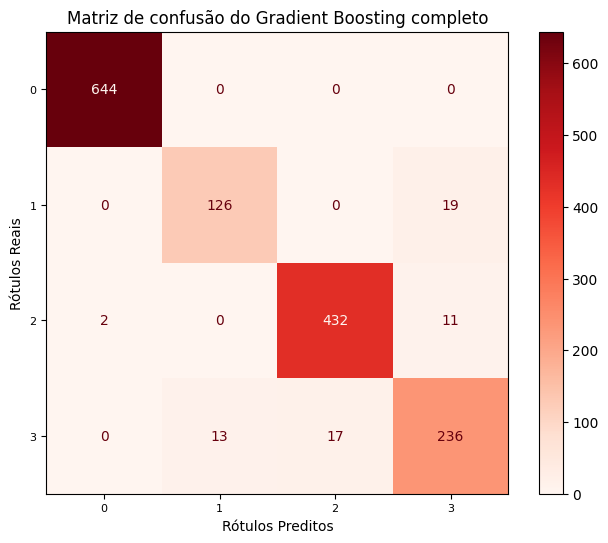

In [234]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, ax = ax, cmap='Reds')

ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)
plt.title("Matriz de confusão do Gradient Boosting completo")
plt.show()

Sabendo que o objetivo deste modelo é aprimorar os resultados a cada passo, podemos analisar também a evolução da média de erros ao longo dos estágios da Gradient Boosting

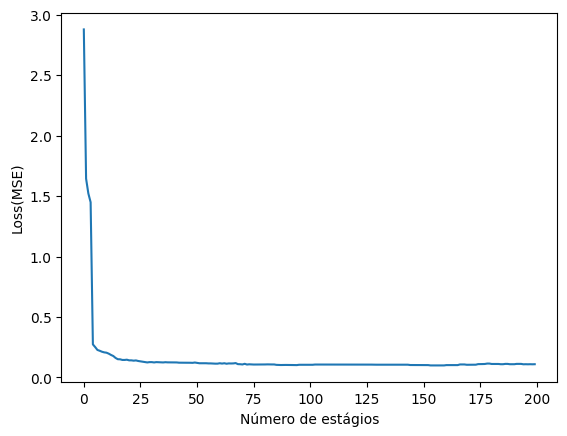

In [235]:
residuos = [mean_squared_error(y_test, y_pred) for y_pred in clf.staged_predict(X_test)]

plt.plot(residuos)
plt.ylabel('Loss(MSE)')
plt.xlabel('Número de estágios')
plt.show()

##### Com early stopping

Iterações necessárias:  158

Métricas 
Acurácia: 0.96 
F1-score: 0.93 
Precisão: 0.94 
Recall: 0.93


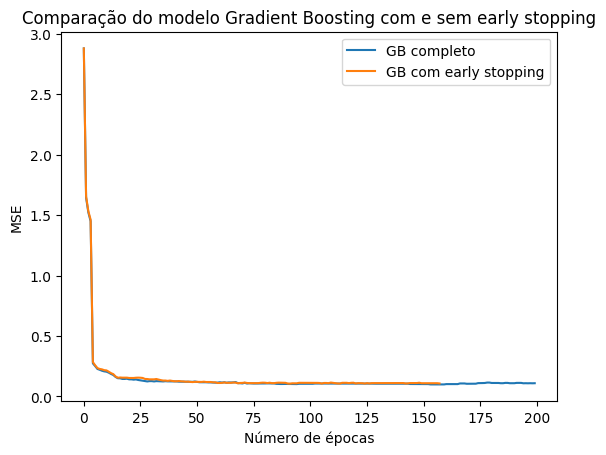

In [236]:

clf_early_stopping = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=5,
    subsample= 0.8,
    validation_fraction=0.1,  # Pega uma parte dos dados de treino usada para validação interna
    n_iter_no_change=10,      # Para se não houver melhoria após 10 iterações  
    tol= 0.001,               # Valor de tolerância
    random_state=42
)

clf_early_stopping.fit(X_train, y_train)

y_pred_earlystopping = clf.predict(X_test)
print("Iterações necessárias: ", clf_early_stopping.n_estimators_)

acuracia_es = accuracy_score(y_test, y_pred_earlystopping)
f1_es = f1_score(y_test, y_pred_earlystopping, average='macro')
precisao_es = precision_score(y_test, y_pred_earlystopping, average='macro')
recall_es = recall_score(y_test, y_pred_earlystopping, average='macro')


print(f"\nMétricas \nAcurácia: {acuracia_es:.2f} \nF1-score: {f1_es:.2f} \nPrecisão: {precisao_es:.2f} \nRecall: {recall_es:.2f}")

residuos_es = [mean_squared_error(y_test, y_pred_earlystopping) for y_pred_earlystopping in clf_early_stopping.staged_predict(X_test)]

plt.plot(residuos, label="GB completo")
plt.plot(residuos_es, label="GB com early stopping")
plt.ylabel('MSE')
plt.xlabel('Número de épocas')
plt.legend()
plt.title("Comparação do modelo Gradient Boosting com e sem early stopping")
plt.show()

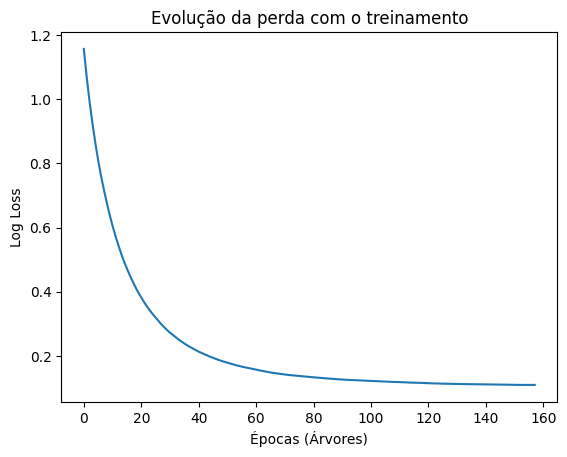

In [237]:
losses = []
for y_pred in clf_early_stopping.staged_predict_proba(X_test):
    losses.append(log_loss(y_test, y_pred))

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Épocas (Árvores)")
plt.ylabel("Log Loss")
plt.title("Evolução da perda com o treinamento")
plt.show()

### Gradient Boosting com validação cruzada

A validação cruzada consiste em dividir o conjunto de dados em K partes (ou folds) e, a cada iteração, usa-se K-1 folds para o treino do modelo e o K restante, para o teste. Essa técnica permite que todos os dados sejam usados tanto para treino quanto para validação, buscando garantir uma validação mais robusta e menos enviesada.

In [238]:
# Definindo o número de folds utilizado
num_folds = 5

In [239]:
metricas_desejadas = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [240]:
modelo_kfold = GradientBoostingClassifier(n_estimators=100, 
                                learning_rate=0.1, 
                                max_depth=3,
                                min_samples_split= 5,
                                min_samples_leaf=5,
                                subsample= 0.8,
                                random_state=42)

In [241]:
# A função cross_validate realiza o treino e o teste do modelo
resultados_validacaocruzada = cross_validate(modelo_kfold, X, y, scoring=metricas_desejadas, cv=num_folds)

acuracia_kfold = resultados_validacaocruzada['test_accuracy'].mean()
precisao_kfold= resultados_validacaocruzada['test_precision_macro'].mean()
f1_kfold = resultados_validacaocruzada['test_f1_macro'].mean()
recall_kfold = resultados_validacaocruzada['test_recall_macro'].mean()

print("Métricas\n")
print(f"Acurácia: {acuracia_kfold:.2f} \nPrecisão: {precisao_kfold:.2f} \nRecall: {recall_kfold:.2f} \nF1-score: {f1_kfold:.2f}")

Métricas

Acurácia: 0.95 
Precisão: 0.94 
Recall: 0.93 
F1-score: 0.93


In [242]:
erro_quadrado_kfold = cross_validate(modelo_kfold, X, y, cv=5, scoring='neg_mean_squared_error')

mse_folds = -erro_quadrado_kfold['test_score']


plt.plot(range(1, 6), mse_folds, marker='o')
plt.title('Erro Quadrático Médio por Fold')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()

KeyboardInterrupt: 

### Gradient Boosting com GridSearch

A técnica de GridSearchCV realiza uma busca sobre um conjunto de parâmetros predefinidos afim de evitar a arbitrariedade em um único modelo. Utilizá-la ao implementar um algoritmo de Gradient Boosting permite que tenhamos uma maior variedade de modelos para análise de sua eficiência de acordo com seus hiperparâmetros. Assim, nesta parte, faremos a implementação do GridSearch junto ao Gradient Boosting para explorarmos novos modelos e compararmos com os obtidos anteriormente.

In [ ]:
grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.05, 0.05],
    'min_samples_split': [1, 5, 10],
    'min_samples_leaf': [1, 5],
    'subsample': [0.8, 1]
 }


grid_search_gb = GridSearchCV(estimator = GradientBoostingClassifier(random_state = 42),
                           param_grid = grid_gb,
                           cv = 5,
                           n_jobs = -1,
                           scoring = 'f1_macro',
                           verbose= 2)

grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\proje\.conda\envs\env_test\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\proje\.conda\envs\env_test\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proje\.conda\envs\env_test\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\proje\.conda\envs\env_test\Lib\site-packages\skle

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.05],
                         'max_depth': [3, 5, 10], 'min_samples_leaf': [1, 5],
                         'min_samples_split': [1, 5, 10],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='f1_macro', verbose=2)

In [ ]:
print("Melhores parâmetros encontrados:", grid_search_gb.best_params_)
print(f"Melhor F1-score médio: {grid_search_gb.best_score_}")

Melhores parâmetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 1}
Melhor F1-score médio: 0.9382256947616419


In [ ]:
y_pred_gs = grid_search_gb.best_estimator_.predict(X_test)

acuracia_gs = accuracy_score(y_test, y_pred_gs)
precisao_gs = precision_score(y_test, y_pred_gs, average = 'macro') 
recall_gs = recall_score(y_test, y_pred_gs, average = 'macro')
f1_gs = f1_score(y_test, y_pred_gs, average = 'macro')

Métricas

Acurácia: 0.95 
Precisão: 0.93 
Recall: 0.93 
F1-Score: 0.93


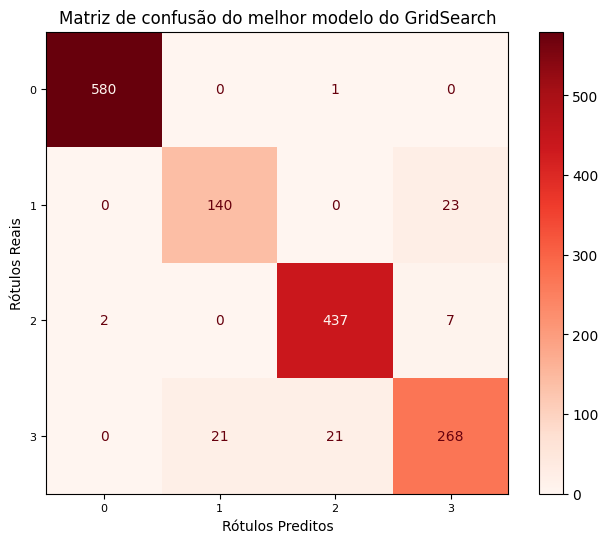

In [ ]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gs, ax = ax, cmap='Reds')

plt.title('Matriz de confusão do melhor modelo do GridSearch')
ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

C:\Users\proje\AppData\Local\Temp\ipykernel_2768\2748990280.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


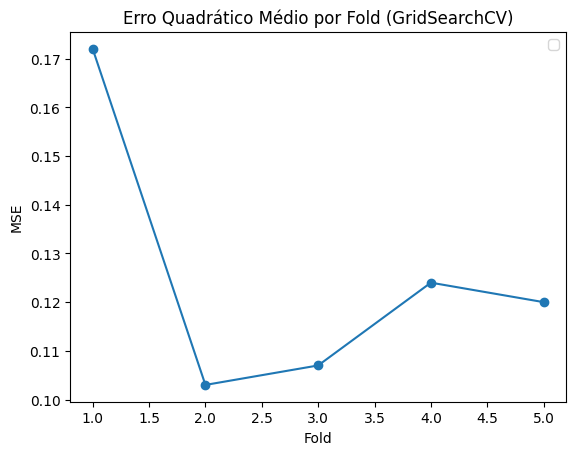

In [ ]:
resultados_modelo_final = cross_validate(grid_search_gb.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')


mse_folds = -resultados_modelo_final['test_score']


plt.plot(range(1, 6), mse_folds, marker='o')
plt.title('Erro Quadrático Médio por Fold (GridSearchCV)')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()

### XGBoost

O XGBoost consiste em uma versão otimizada do Gradient Boosting desenvolvido anteriormente. Ele é o aprimoramento desse modelo em aspectos como velocidade, desempenho e escalabilidade. Nesta parte, iremosdesenvolver um modelo de XGBoost para compará-lo com os modelos anteriores e ver se ele se adequa ao cenário deste projeto.

In [ ]:
xboosting = XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.1, random_state= 42)

In [ ]:
modelo_xgb = XGBClassifier(objective='multi:softprob', # Define o problema como multiclasse
                                num_class=4, # Número de classes
                                eval_metric='mlogloss', 
                                n_estimators=100,
                                learning_rate=0.1,
                                max_depth=3,
                                use_label_encoder=False,
                                
                                random_state=42)


In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
modelo_xgb.fit(X_train, y_train, eval_set= eval_set, verbose= False)

resultados_xgb = modelo_xgb.evals_result()


c:\Users\proje\.conda\envs\env_test\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:21:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
modelo_xgb.fit(X_train, y_train, eval_set= eval_set, verbose= False)

resultados_xgb = modelo_xgb.evals_result()

In [ ]:
pred_xgb = modelo_xgb.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       581
           1       0.90      0.85      0.87       163
           2       0.95      0.99      0.97       446
           3       0.90      0.87      0.88       310

    accuracy                           0.95      1500
   macro avg       0.93      0.93      0.93      1500
weighted avg       0.95      0.95      0.95      1500



In [ ]:
acuracia_xgb = accuracy_score(y_test, pred_xgb)
f1_xgb = f1_score(y_test, pred_xgb, average= 'macro')
recall_xgb = recall_score(y_test, pred_xgb, average= 'macro')
precisao_xgb = precision_score(y_test, pred_xgb, average= 'macro')

print("Métricas \n")
print(f"Acurácia: {acuracia_xgb:.2f} \nPrecisão: {precisao_xgb:.2f} \nRecall: {recall_xgb:.2f} \nF1-Score: {f1_xgb:.2f}")

Métricas 

Acurácia: 0.95 
Precisão: 0.93 
Recall: 0.93 
F1-Score: 0.93


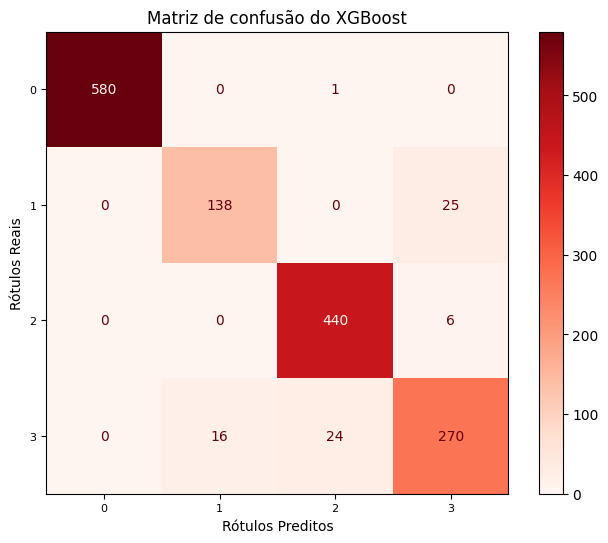

In [ ]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, pred_xgb, ax = ax, cmap='Reds')

plt.title('Matriz de confusão do XGBoost')
ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

In [ ]:
resultados_xgb['validation_0']['mlogloss']

[1.2372569006511143,
 1.1131513229438237,
 1.00915600502491,
 0.921441138625145,
 0.8444265897614616,
 0.7779563207285745,
 0.718938599893025,
 0.6668831982953208,
 0.6201091595717839,
 0.5775205275927271,
 0.5391763228433473,
 0.5063011211071695,
 0.47518309071234294,
 0.44793457587276186,
 0.42369441750645637,
 0.4005129486364978,
 0.37969556961740764,
 0.3605439235695771,
 0.3438299703683172,
 0.3280124394489186,
 0.31358452485076016,
 0.29996413927844595,
 0.28791703941566604,
 0.2764221481042249,
 0.265298442534038,
 0.25570965944230556,
 0.2466609116920403,
 0.23835398872196675,
 0.23038471056627377,
 0.22294416580029897,
 0.21594991850746528,
 0.20956104197033815,
 0.2037508267547403,
 0.19757256777052368,
 0.19242153857116187,
 0.18758510753405946,
 0.1824134022018739,
 0.177609337285161,
 0.17315824849211744,
 0.16917266559813704,
 0.16533323222079446,
 0.161578516757914,
 0.1575050994195044,
 0.15418793460513863,
 0.15107629151589105,
 0.14793126648957175,
 0.1451984728250120

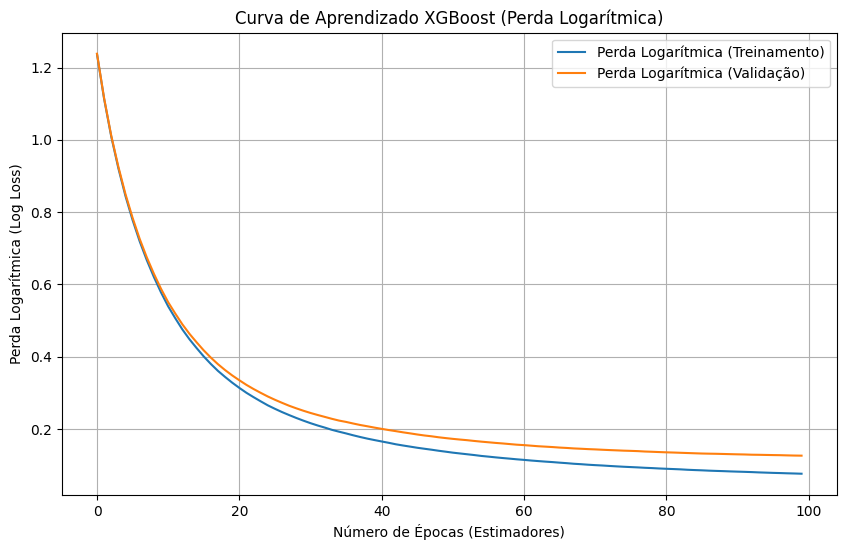

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(range(0, 100), resultados_xgb['validation_0']['mlogloss'], label='Perda Logarítmica (Treinamento)')
plt.plot(range(0, 100), resultados_xgb['validation_1']['mlogloss'], label='Perda Logarítmica (Validação)')
plt.xlabel('Número de Épocas (Estimadores)')
plt.ylabel('Perda Logarítmica (Log Loss)')
plt.title('Curva de Aprendizado XGBoost (Perda Logarítmica)')
plt.grid(True)
plt.legend()
plt.show()

### RandomizedSearchCV

O modelo RandomizedSearchCV é bem similar ao modelo de GridSearchCV. Criamos um grid de possíveis configurações que o modelo deve testar, no entanto, apenas uma determinada quantidade deles (n_iter), escolhidos aleatoriamente, serão de fato implementados. O intuito é acrescentar ainda mais aleatoriedade para o modelo, tendo em vista que podemos ampliar o campo de possibilidades de parâmetros que serão amostrados.

In [ ]:
parametros_rs = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.6, 0.4),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

In [ ]:
modelo_rs = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator= modelo_rs,
    param_distributions= parametros_rs,
    n_iter=10,
    cv= 5,
    n_jobs= -1,
    scoring= 'f1_macro',
    verbose=2
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\proje\.conda\envs\env_test\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\proje\.conda\envs\env_test\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\proje\.conda\envs\env_test\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\proje\.conda\envs\env_test\Lib\site-packages\sklearn\

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018F8783B350>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018FA2E1CA50>,
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_s...object at 0x0000018FA3532040>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018F8CD2D9D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018FA2B91EB0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018F89AAC6B0>},
                   scoring='f1_macro', verbose=2)

In [ ]:
print("Melhores parâmetros encontrados:", random_search.best_params_)
print(f"Melhor F1-score médio: {random_search.best_score_}")

Melhores parâmetros encontrados: {'learning_rate': np.float64(0.026849789101684896), 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 17, 'min_samples_split': 4, 'n_estimators': 232, 'subsample': np.float64(0.8476901043530527)}
Melhor F1-score médio: 0.939923102528088


In [ ]:

pred_rs = random_search.best_estimator_.predict(X_test)

# Métricas de avaliação no conjunto de teste
acuracia_rs = accuracy_score(y_test, pred_rs)
precisao_rs = precision_score(y_test, pred_rs, average = 'macro')
recall_rs = recall_score(y_test, pred_rs, average = 'macro')
f1_rs = f1_score(y_test, pred_rs, average = 'macro')


print("Métricas \n")
print(f"Acurácia: {acuracia_rs:.2f} \nPrecisão: {precisao_rs:.2f} \nRecall: {recall_rs:.2f} \nF1-Score: {f1_rs:.2f}")

Métricas 

Acurácia: 0.95 
Precisão: 0.93 
Recall: 0.93 
F1-Score: 0.93


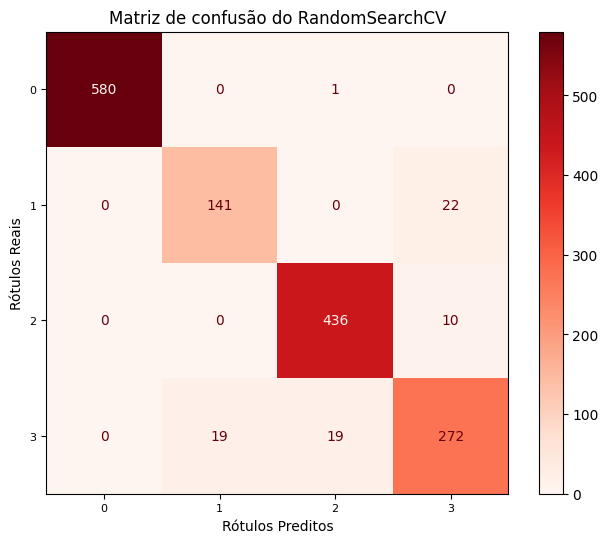

In [ ]:
# Matriz de confusão
fig, ax = plt.subplots(figsize = (8, 6))

disp = ConfusionMatrixDisplay.from_predictions(y_test, pred_rs, ax = ax, cmap='Reds')

plt.title('Matriz de confusão do RandomSearchCV')
ax.set_xlabel("Rótulos Preditos", fontsize = 10)
ax.set_ylabel("Rótulos Reais", fontsize = 10)

ax.tick_params(axis = 'both', labelsize = 8)

plt.show()

In [ ]:
os.makedirs('gradient_boosting', exist_ok = True)
joblib.dump(clf, 'gradient_boosting/gradientboosting_air_quality_standard.joblib')
joblib.dump(grid_search_gb.best_estimator_, 'gradient_boosting/final_model_gridsearch.joblib')
joblib.dump(resultados_validacaocruzada, 'gradient_boosting/crossvalidate_results.joblib')
joblib.dump(modelo_xgb, 'gradient_boosting/xgboost.joblib')
joblib.dump(random_search.best_estimator_, 'gradient_boosting/final_model_random_search.joblib')

['gradient_boosting/final_model_random_search.joblib']

### Conclusão

In [ ]:
data = {
    'Modelo': ['Gradient Boosting Padrão', 'Melhor modelo do GridSearch', 'XGBoost', 'Melhor modelo do RandomizedSearch'],
    'Acurácia': [acuracia_gb, acuracia_gs, acuracia_xgb, acuracia_rs],
    'Precisão': [precisao_gb, precisao_gs, precisao_xgb, precisao_rs],
    'Recall': [recall_gb, recall_gs, recall_xgb, recall_rs],
    'F1-Score': [f1_gb, f1_gs, f1_xgb, f1_rs]
}


df_resultados = pd.DataFrame(data)

colunas_metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
df_resultados[colunas_metricas] = df_resultados[colunas_metricas].map(lambda x: f"{x * 100:.2f}%")


print("\nComparação de Modelos\n")
print(df_resultados.to_string(index = False))


Comparação de Modelos

                           Modelo Acurácia Precisão Recall F1-Score
         Gradient Boosting Padrão   95.13%   93.24% 92.53%   92.86%
      Melhor modelo do GridSearch   95.00%   92.94% 92.54%   92.72%
                          XGBoost   95.20%   93.48% 92.56%   92.99%
Melhor modelo do RandomizedSearch   95.27%   93.30% 92.96%   93.12%


O objetivo deste notebook foi explorar o modelo de aprendizado máquinas Gradient Boosting e suas variações, além de ver como o mesmo atuaria sobre a base de dados escolhida para o trabalho. Avaliando as métricas levantas ao longo deste documento, podemos concluir que o modelo de Gradient Boosting com uso de RandomizedSearch obteve o melhor desempenho em métricas como f1-score macro e acurácia.

Dentre as hipóteses para justificar estes resultados, podemos citar a exploração em um espaço mais amplo que este modelo oferece, ao fazer combinações aleatórias dos hiperparâmetros que o modelo Gradient Boosting utiliza.
